# Create a sphere
* specify size of a box in nm, it wil be centered around 0
* specify the resolution of the axis with nPoints - make it an odd number (if running LOCALLY, DO NOT set it bigger than 101)
* optionally specify the volume fraction, up until which the vox will be filled, default is 0.05
* call a `place_shape` function to create spheres in a box, specify `single=True` if you want to create just a single sphere
* when calling a `place_shape` you can also specify such parameters as rMean and rWidth to sample radius and length from a normal distribution with certain mean and standard deviation.  

In [1]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

In [2]:
simulation = Sphere(size = 10, nPoints = 501, volFrac = 0.05)
simulation.place_shape(rMean = 0.55, rWidth = 0.08)

volume fraction is 0.00084, radius is 0.59, center at (-4.0,-4.3,0.6) 
volume fraction is 0.00218, radius is 0.68, center at (3.8,3.0,0.2) 
volume fraction is 0.00362, radius is 0.70, center at (-2.7,1.1,-1.7) 
volume fraction is 0.00468, radius is 0.63, center at (3.5,-0.4,-0.2) 
volume fraction is 0.00580, radius is 0.65, center at (1.4,0.7,-0.4) 
volume fraction is 0.00652, radius is 0.56, center at (-2.3,0.2,2.1) 
volume fraction is 0.00716, radius is 0.54, center at (1.9,-1.2,-2.0) 
volume fraction is 0.00882, radius is 0.74, center at (0.7,3.6,3.1) 
volume fraction is 0.00988, radius is 0.63, center at (2.2,-4.0,-0.4) 
volume fraction is 0.01056, radius is 0.55, center at (1.7,3.6,4.1) 
volume fraction is 0.01138, radius is 0.58, center at (2.8,4.0,-0.7) 
volume fraction is 0.01207, radius is 0.55, center at (-0.3,-3.6,1.6) 
volume fraction is 0.01272, radius is 0.54, center at (-2.8,2.1,-4.0) 
volume fraction is 0.01326, radius is 0.51, center at (-1.4,-1.4,-3.6) 
volume fractio

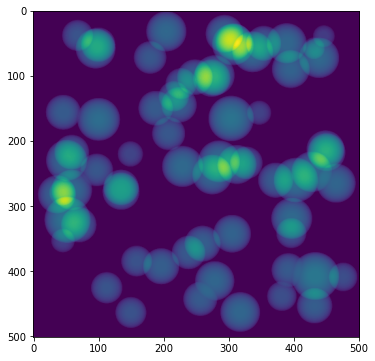

In [3]:
# the box summed on X-axis
plt.figure(figsize=(6,6))
plt.imshow(simulation.density.sum(axis=0));

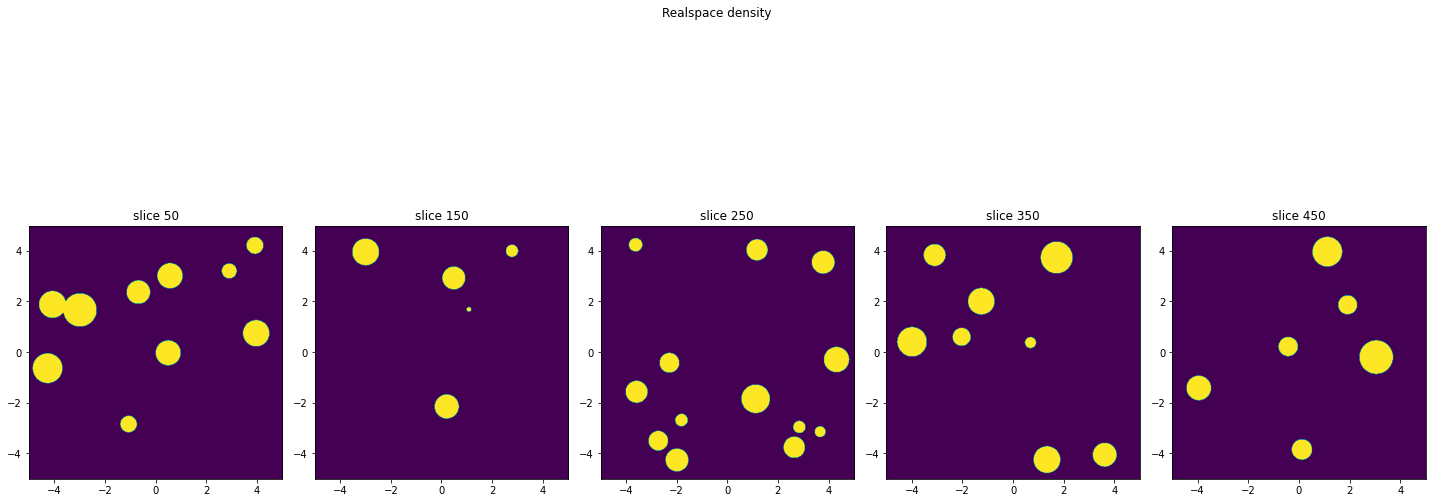

In [4]:
# plot the sampled density at 5 equally-distances slices
plot_slices(simulation.density, simulation.grid)

In [5]:
# takes some time
# plot_3D_structure(simulation.density, simulation.grid, realspace=True)

In [6]:
# pin memory for the GPU usage
# don't need to run when no PGU available
simulation.pin_memory()

## There are few options to calculate the Fourier Transform of a structure:
1) with a class method `calculate_custom_FTI_3D_slice` - custom calculator for a central slice only
2) with a class method `calculate_custom_FTI_3D` - custom calculator for the whole 3D Fourier transform of a structure density
3) with a class method `calculate_torch_FTI_3D` - calls torch's fftn, also speciies value for a central slice as an attribute

In [7]:
# calculate FT at central slice, specify device to 'cpu' if no GPUs available
simulation.calculate_custom_FTI_3D_slice(device = 'cuda') 

In [8]:
#simulation.calculate_custom_FTI_3D(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cuda')

the maximal difference between the implementation of the FTI is 0.06635376513382209


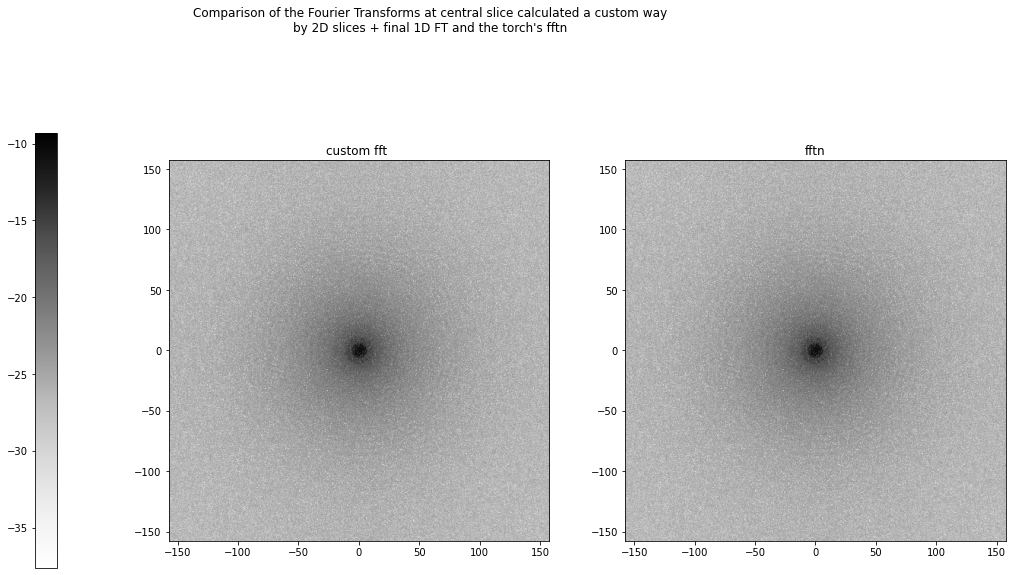

In [9]:
#difference in fft of central slice
plot_FTI_version_center(simulation.FTI_slice_custom, simulation.FTI_slice_torch, simulation.qx)

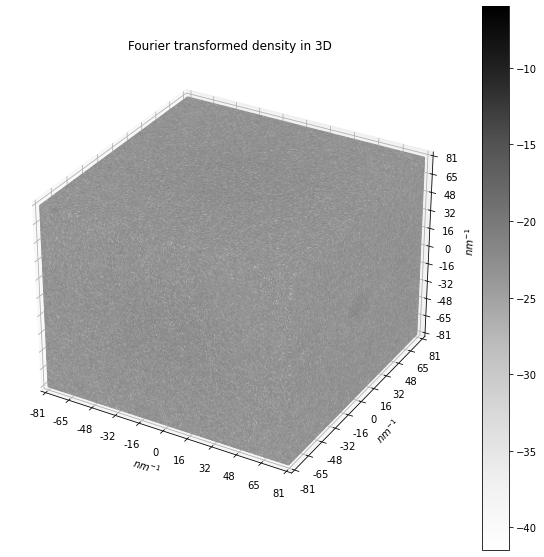

In [19]:
# don't plot on big scale, takes time!
# import torch
#plot_3D_structure(torch.from_numpy(simulation.FTI), simulation.qx, realspace= False)#, path = 'figures/FFT_spheres_example.png')

## The rebinning procedure. 
* before that iternally applies the sinc function
* specify the number of bins
* note, that rebinning is not performed for all calculated intensities, but only for those within the sphere inside of a box to achieve more consistent averaged values, since the "corner" values are under-represented
* after the rebinning is done, remove the very first bin, because it always contains 1 point and is the smallest possible angle, which just represents the scaling of Q 

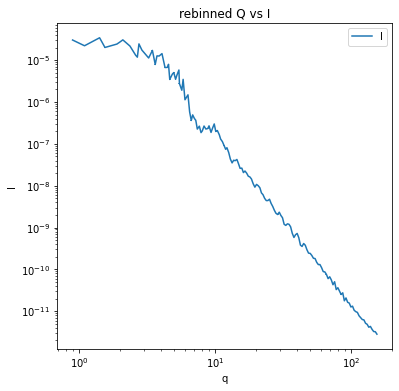

In [10]:
simulation.reBin(200, slice = 'center')
simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

## Comparing to SasModels
* uses the SasModells API under the hood
* initializes the model with same values for radius and polidispersity as for simulated spheres in a box (sets background to 0, SLD to 1 and SLD solvent to 0)
* initialization is performed for same values of Q, as present after the rebinning 
* plots the comparison between Sphere simulation in a box and a SasModels simulation



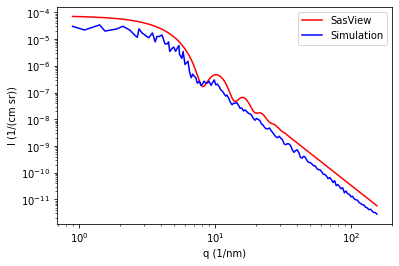

In [26]:
simulation.init_sas_model()
plot_simulation_vs_sas( simulation.binned_slice, simulation.qx_sas, simulation.I_sas)

In [68]:
simulation.update_scaling((simulation.binned_slice.I.values / simulation.I_sas).mean())
simulation.modelParameters_sas

{'scale': 1.1131274387461383,
 'background': 0.0,
 'sld': 1.0,
 'sld_solvent': 0.0,
 'radius': 0.55,
 'up_frac_i': 0.0,
 'up_frac_f': 0.0,
 'up_angle': 0.0,
 'up_phi': 0.0,
 'sld_M0': 0.0,
 'sld_mtheta': 0.0,
 'sld_mphi': 0.0,
 'sld_solvent_M0': 0.0,
 'sld_solvent_mtheta': 0.0,
 'sld_solvent_mphi': 0.0,
 'radius_pd': 0.08,
 'radius_pd_type': 'gaussian',
 'radius_pd_n': 35}

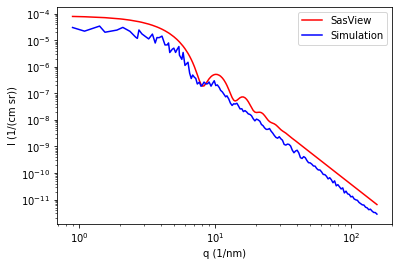

In [69]:
plot_simulation_vs_sas( simulation.binned_slice, simulation.qx_sas, simulation.I_sas)

In [67]:
simulation.save_data(uncertainty =  'IError',directory='dat_files')
print("the sphere file with radius {r:.3f}  is saved".format(r = simulation.rMean))

the sphere file with radius 0.550  is saved


# Create a Cylinder
Similarly define the box where a cylinder will be placed and then call a function to place cylinders. One can again specify the argument to create just one cylinder, and also create cylinders of certain size by specifying rMean, hMean and rWidth hWidth to sample cylinders of certain radius and length and specifying theta and phi for the angles.
Currently creates cylinders such that one of the angles is aligned with some axis in a box.

In [1]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

simulation = Cylinder(size = 10, nPoints = 251, volFrac = 0.05)
simulation.place_shape()

rMean 0.4065975416781017
volume fraction is 0.00121, height is 4.695, radius is 0.288, center at (-3.1,-1.8,-2.2), rotation phi is 38.8, rotation theta is -88.8 
volume fraction is 0.00410, height is 4.847, radius is 0.438, center at (2.0,-2.4,-3.3), rotation phi is 9.9, rotation theta is -87.3 
volume fraction is 0.00604, height is 4.693, radius is 0.365, center at (2.7,-3.4,-3.9), rotation phi is 53.5, rotation theta is -94.1 
volume fraction is 0.00767, height is 5.181, radius is 0.320, center at (1.8,0.3,-1.9), rotation phi is 4.4, rotation theta is -92.6 
volume fraction is 0.01107, height is 4.804, radius is 0.517, center at (-3.3,-1.5,-3.2), rotation phi is 21.9, rotation theta is -88.0 
volume fraction is 0.01382, height is 4.666, radius is 0.433, center at (-4.2,2.4,-1.1), rotation phi is 3.8, rotation theta is -90.0 
volume fraction is 0.01653, height is 4.815, radius is 0.426, center at (-1.4,-0.7,-1.1), rotation phi is 63.1, rotation theta is -92.5 
volume fraction is 0.019

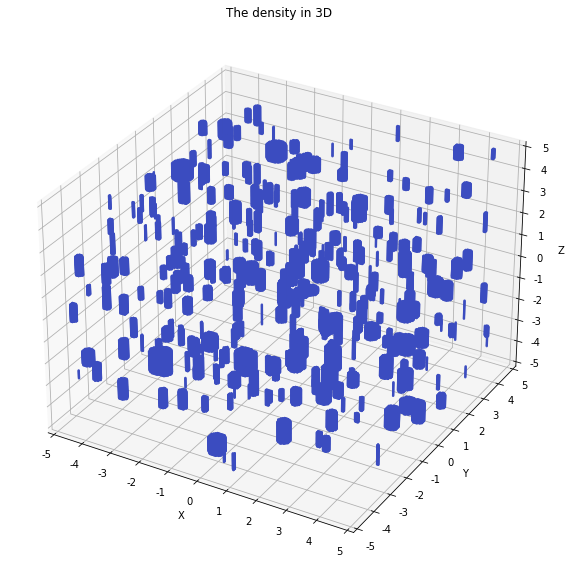

In [2]:
# takes a while 
# plot_3D_structure(simulation.density, simulation.grid, realspace=True)

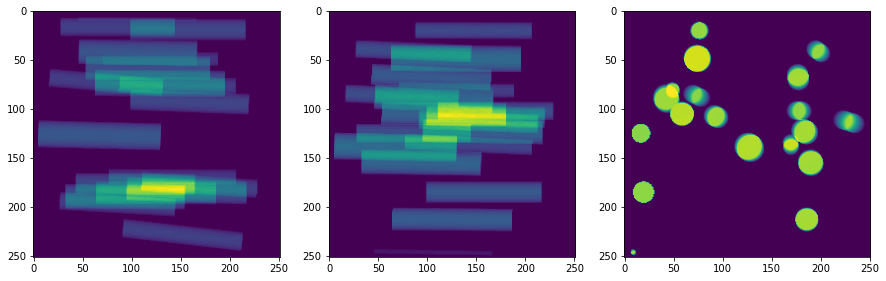

In [2]:
#plot_slices(simulation.density, simulation.grid, direction ='z')
# look at the sum on each slice
plt_slices_sum(simulation)

look at some slices on each axis

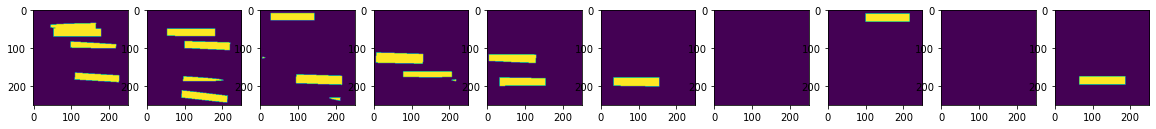

In [3]:
plot_slices_at_interval(12, 100, simulation, 'x')

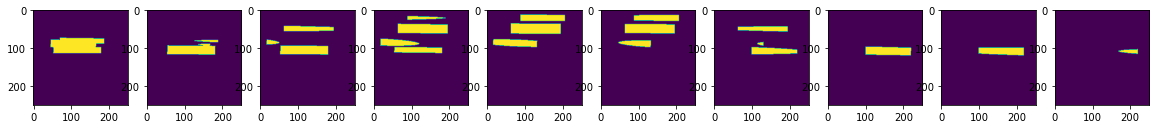

In [4]:
plot_slices_at_interval(6, 50, simulation, 'y')

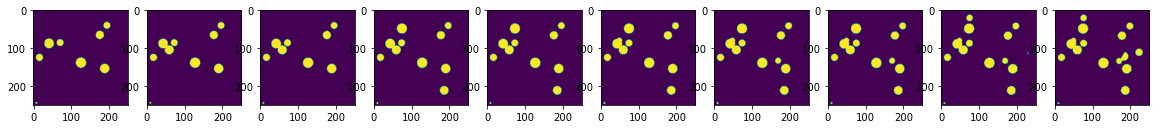

In [5]:
plot_slices_at_interval(5, 50, simulation, 'z')

In [6]:
simulation.pin_memory()

compare the central slices of custom and torch's implementation

/home/slaskina/SAXS-simulations/SAXSsimulations/create_form.py:134: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/Copy.cpp:250.)
  if FT[:,i,j].any():


the maximal difference between the implementation of the FTI is 0.0023236395541477712


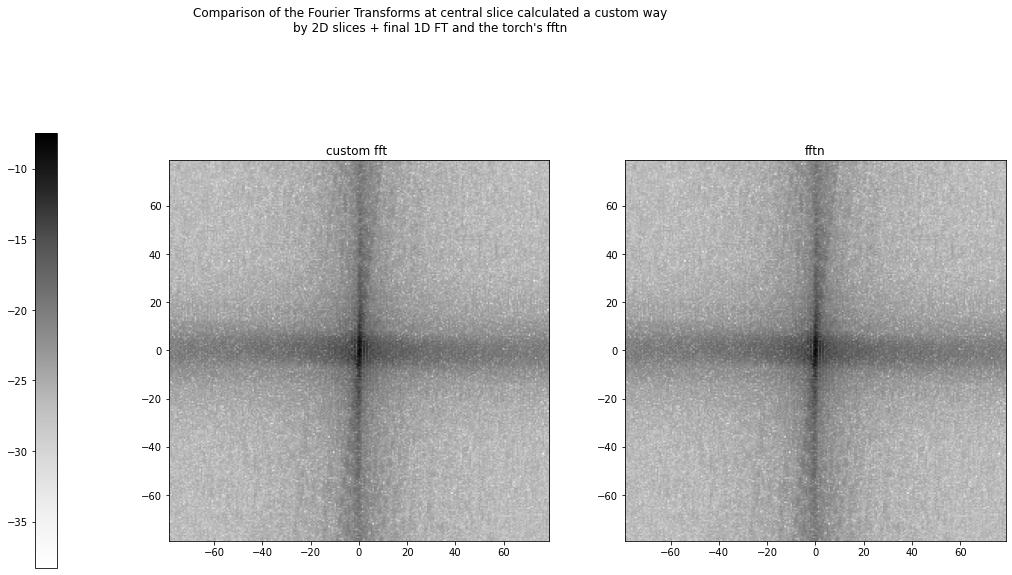

In [7]:
simulation.calculate_custom_FTI_3D_slice(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cpu')

plot_FTI_version_center(simulation.FTI_slice_custom, simulation.FTI_slice_torch, simulation.qx)

In [7]:
simulation.calculate_custom_FTI_3D(device = 'cpu')

### this function allows to look at the central slice of FT in any direction
but for it to work, we need to calculate FT for the whole box

In [8]:
def plt_slices_sim(simulation):
    fig,axs = plt.subplots(1,3,figsize = (15,5))
    ax = axs[0]
    im = ax.imshow(np.log(simulation._FTI_custom[126,:,:]), cmap = 'Greys')
    ax = axs[1]
    im = ax.imshow(np.log(simulation._FTI_custom[:,126,:]), cmap = 'Greys')
    ax = axs[2]
    im = ax.imshow(np.log(simulation._FTI_custom[:,:,126]), cmap = 'Greys')
    plt.show()    


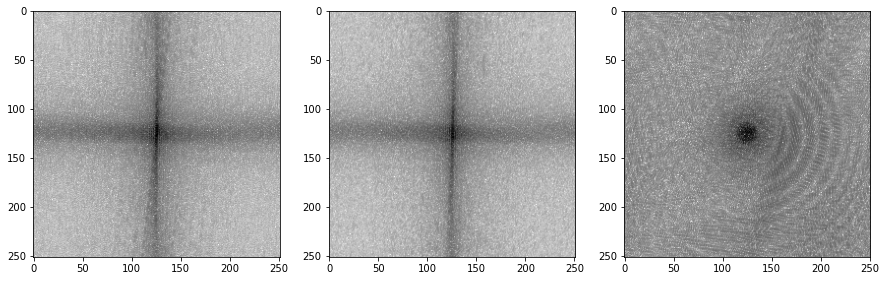

In [10]:
simulation.calculate_custom_FTI_3D(device = 'cpu')
plt_slices_sim(simulation)

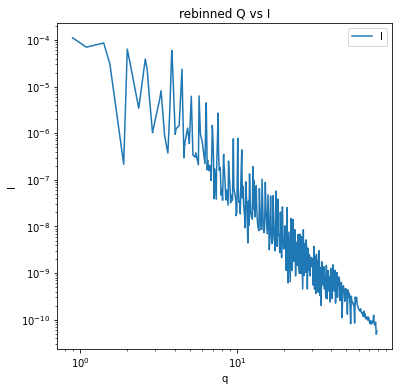

In [15]:
simulation.reBin(500, slice = 'center')
simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

In [18]:
simulation.save_data(uncertainty = 'IError', directory='dat_files')
print("the cylinder file with radius {r:.3f} and height {h:.3f} is saved".format(r = simulation.rMean, h = simulation.hMean))

the cylinder file with radius 0.407 and height 4.863 is saved


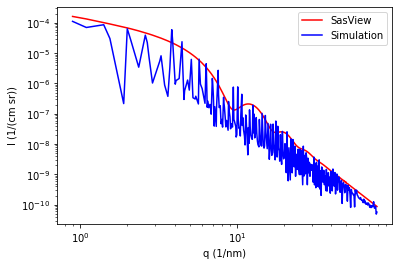

In [17]:
simulation.init_sas_model()
plot_simulation_vs_sas( simulation.binned_slice, simulation.qx_sas, simulation.I_sas)